# Decode stimuli from neural activity

In [25]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm

%matplotlib notebook

In [2]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
]

In [4]:
# This object will contain all relevant experiment data

class Session:
    
    def __init__(self,params=None,path=None):
        
        #load trials
        self.trials=pd.read_csv(os.path.join(path,'trials_table.csv'))
        trial_stim_dur=np.zeros(len(self.trials))
        for tt in range(0,len(self.trials)):
            if self.trials['trial_sound_dur'].iloc[tt]>0:
                trial_stim_dur[tt]=self.trials['trial_sound_dur'].iloc[tt]
            elif self.trials['trial_vis_stim_dur'].iloc[tt]>0:
                trial_stim_dur[tt]=self.trials['trial_vis_stim_dur'].iloc[tt]

        self.trials['trial_stim_dur']=trial_stim_dur
        
        #load lick times
        self.lick_times=np.load(os.path.join(path,'lick_times.npy'),allow_pickle=True)
        self.lick_times=self.lick_times[0]
        
        #load units
        self.units=pd.read_csv(os.path.join(path,'unit_table.csv'))
        self.units=self.units.set_index('id')
        self.good_units=self.units.query('quality == "good" and \
                        isi_viol < 0.5 and \
                        amplitude_cutoff < 0.1 and \
                        presence_ratio > 0.95')
        self.good_units=self.good_units.sort_values(by=['probe','peak_channel'])
        
        #load spike times
        self.spike_times=np.load(os.path.join(path,'spike_times_aligned.npy'),allow_pickle=True).item()
        
        #load frames
        self.frames=pd.read_csv(os.path.join(path,'frames_table.csv'))
        


## Load a single session

In [5]:
sel_session=0
session=Session(path=main_path[sel_session]) 

In [6]:
# trials table
session.trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,vis1,vis1,True,True,0.00,0.5,True,False,...,False,False,False,False,False,False,238,112.733125,0.020675,0.50
1,1,419,vis1,vis1,True,True,0.00,1.0,True,False,...,False,False,False,False,False,False,531,117.620575,0.020675,1.00
2,2,712,vis1,vis1,True,True,0.00,0.5,True,False,...,False,False,False,False,False,False,812,122.309625,0.022505,0.50
3,3,993,vis1,vis1,True,True,0.00,1.0,True,False,...,False,False,False,False,False,False,1127,127.564025,0.022505,1.00
4,4,1308,vis1,vis1,True,True,0.00,0.5,True,False,...,False,False,False,False,False,False,1404,132.184510,0.022560,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,668,214241,sound2,vis1,False,False,1.00,0.0,False,False,...,False,False,True,False,False,False,214334,3702.811384,0.021604,1.00
669,669,214515,sound2,vis1,True,False,0.50,0.0,False,False,...,True,False,False,False,False,False,214634,3707.841062,0.013792,0.50
670,670,214815,sound1,vis1,False,False,0.75,0.0,False,False,...,False,True,False,False,False,False,214915,3712.561547,0.013667,0.75
671,671,215096,sound1,vis1,False,False,1.00,0.0,False,False,...,False,True,False,False,False,False,215358,3720.021197,0.017167,1.00


In [128]:
# units table
session.good_units

,quality,peak_channel,waveform_duration,probe,amplitude,index,cluster_id,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,silhouette_score,max_drift,cumulative_drift,epoch_name
id,,,,,,,,,,,,,,,,,,,,
2207261420002,good,6,0.833332,B,5.614287,2,2,3.828723,0.99,0.000000,0.010085,34.409595,0.159389,3.846623,0.925333,0.014425,0.180270,53.36,201.82,complete_session
2207261420015,good,17,0.200000,B,3.503750,15,15,19.167459,0.99,0.027297,0.002319,105.279829,0.000066,6.368560,0.998000,0.005199,0.154375,11.95,32.07,complete_session
2207261420394,good,20,0.533332,B,4.391291,384,394,0.262524,0.98,0.000000,0.020124,54.379673,0.021180,7.026229,0.958333,0.001040,0.160780,5.57,24.83,complete_session
2207261420019,good,21,0.299999,B,3.082485,19,19,10.065996,0.99,0.004900,0.009541,95.315151,0.008634,4.009885,0.980000,0.053580,0.107769,16.51,155.97,complete_session
2207261420511,good,24,0.599999,B,3.860877,501,511,1.557927,0.99,0.000000,0.004179,87.781215,0.000045,7.506342,1.000000,0.000357,0.128887,11.92,73.84,complete_session
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207261460368,good,170,0.733331,F,4.841153,358,368,4.313745,0.97,0.000000,0.000016,47.723641,0.034797,5.218821,0.984000,0.000349,0.148350,38.75,42.73,complete_session
2207261460369,good,170,0.733331,F,2.812027,359,369,5.737090,0.99,0.024133,0.052339,45.616601,0.050513,3.378733,0.970667,0.002990,0.116484,21.16,69.57,complete_session
2207261460377,good,177,0.699998,F,5.050801,367,377,8.871204,0.99,0.045422,0.000693,87.791434,0.039974,3.946726,0.992667,0.015374,-0.022545,41.59,48.85,complete_session


In [8]:
# spike times from one unit
session.spike_times[session.units.index[0]]

array([  41.32760934,   42.21184105,   44.75940304, ..., 3814.76647693,
       3814.85157677, 3814.92490997])

In [9]:
# information about each frame
session.frames

,Unnamed: 0,vsyncTimes,frameDelay,runningSpeed
0,0,108.74279,0.020675,0.000000
1,1,108.75926,0.020675,0.000000
2,2,108.77597,0.022505,0.000000
3,3,108.79259,0.022505,0.000000
4,4,108.80925,0.022560,0.000000
...,...,...,...,...
215994,215994,3730.67952,0.022535,27.626380
215995,215995,3730.69623,0.022535,27.410549
215996,215996,3730.71288,0.022540,26.978887
215997,215997,3730.72958,0.022540,26.763056


In [10]:
# functions for binning the spiking data into a convenient shape for plotting

def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    '''
    Convenience function to compute a peri-stimulus-time histogram
    (see section 7.2.2 here: https://neuronaldynamics.epfl.ch/online/Ch7.S2.html)
    INPUTS:
        spikes: spike times in seconds for one unit
        startTimes: trial start times in seconds; the first spike count 
            bin will be aligned to these times
        windowDur: trial duration in seconds
        binSize: size of spike count bins in seconds
    OUTPUTS:
        Tuple of (PSTH, bins), where:
            PSTH gives the trial-averaged spike rate for 
                each time bin aligned to the start times;
            bins are the bin edges as defined by numpy histogram
    '''
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins


def make_neuron_time_trials_tensor(units, spike_times, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.001):
    '''
    Function to make a tensor with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_tensor: tensor storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
    '''
    neuron_number = len(units)
    trial_number = len(stim_table)
    unit_tensor = np.zeros((neuron_number, int(trial_duration/bin_size), trial_number))
    
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        unit_spike_times = spike_times[iu]
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            if 'stimStartTime' in trial:
                trial_start = trial.stimStartTime - time_before
            elif 'start_time' in trial:
                trial_start = trial.start_time - time_before
            unit_tensor[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    return unit_tensor

In [189]:
# loop through sessions and make unit xarrays
time_before_flash = 1.5
trial_duration = 3
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### Try simple decoding of stimuli

In [190]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [338]:
# grab data: make these [trials,neurons] matrices based on different time bins:

trial_sel=session.trials.query('trialStimID != "catch"').index
# trial_sel=session.trials.query('trialStimID == "sound1" or \
#                                 trialStimID == "sound2"').index

unit_sel=session.good_units.query('probe == "B"').index
# unit_sel=session.good_units.index

#1: -250:0ms
prestim = session.trial_da.sel(time=slice(-1.5,-1.25),trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
#2: 0:250ms
stim_initial = session.trial_da.sel(time=slice(0,0.25),trials=trial_sel,unit_id=unit_sel).mean(dim='time').values
#3: 250:500ms
stim_steady = session.trial_da.sel(time=slice(0.25,0.5),trials=trial_sel,unit_id=unit_sel).mean(dim='time').values

# grab the stimulus ids
stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)

In [339]:
# split train and test data

X = stim_steady[:,:].T
y = stim_ids

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

In [307]:
# prestim.shape

In [340]:
# train the model

# clf = svm.LinearSVC(kernel='linear', C = 1.0)

# clf = svm.LinearSVC(random_state=0, tol=1e-5)
clf = svm.LinearSVC()

clf.fit(xtrain, ytrain)

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [341]:
score = clf.score(xtrain, ytrain)
print("Score: ", score)

Score:  1.0


In [342]:
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=5)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.76


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

In [343]:
ypred = clf.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

[[43 35  0  0]
 [43 47  0  0]
 [ 1  0 70  0]
 [ 0  0  0 69]]


In [344]:
cr = classification_report(ytest, ypred)
print(cr)

              precision    recall  f1-score   support

      sound1       0.49      0.55      0.52        78
      sound2       0.57      0.52      0.55        90
        vis1       1.00      0.99      0.99        71
        vis2       1.00      1.00      1.00        69

    accuracy                           0.74       308
   macro avg       0.77      0.76      0.77       308
weighted avg       0.75      0.74      0.74       308



In [353]:
cr_dict=classification_report(ytest, ypred, output_dict=True)
pd.DataFrame.from_dict(cr_dict)

,sound1,sound2,vis1,vis2,accuracy,macro avg,weighted avg
precision,0.494253,0.573171,1.000000,1.0,0.743506,0.766856,0.747198
recall,0.551282,0.522222,0.985915,1.0,0.743506,0.764855,0.743506
f1-score,0.521212,0.546512,0.992908,1.0,0.743506,0.765158,0.744601
support,78.000000,90.000000,71.000000,69.0,0.743506,308.000000,308.000000


In [346]:
#decision function - per trial, distance from hyperplane -- represents confidence in classification
clf.decision_function(xtrain)

array([[ -7.25846336, -10.62844011,   1.30526382,  -1.71568979],
       [  1.00066846,  -1.15679518,  -1.24879777,  -1.43409792],
       [ -8.93186321, -10.20776299,  -1.83821027,   2.30098735],
       ...,
       [ -1.0063136 ,   0.99429935,  -1.54989715,  -1.51063988],
       [ -7.6273039 ,  -8.8332418 ,  -1.94711686,   1.44719523],
       [-10.55357704,  -4.83419469,  -1.12669337,   1.38373829]])

<IPython.core.display.Javascript object>


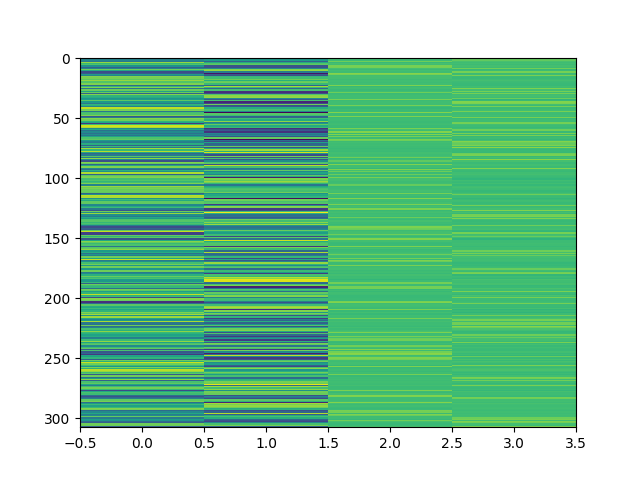

In [348]:
fig,ax=plt.subplots(1,1)
ax.imshow(clf.decision_function(xtest),aspect='auto',interpolation='none')